In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import rosbag
import pymap3d as pm

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

@nb.njit()
def to_euler(x, y, z, w):
    """Dari Coursera: Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])
# Compile the to_euler
_ = to_euler(1.5352300785980803e-15, -1.3393747145983517e-15, -0.7692164172827881, 0.638988343698562)

def calculate_s(wp_x, wp_y):
    s = np.zeros(wp_x.shape[0])
    for i in range(1, s.shape[0]):
        s[i] = s[i-1] + np.sqrt((wp_x[i] - wp_x[i-1])**2 + (wp_y[i] - wp_y[i-1])**2)
    return s

In [3]:
bag = rosbag.Bag('data_fixed/belok_1.bag')
# bag = rosbag.Bag('data_fixed/lurus_s_1.bag')
# bag = rosbag.Bag('data_fixed/lurus_s_2.bag')
# bag = rosbag.Bag('data_fixed/lurus_s_3.bag')
# bag = rosbag.Bag('data_fixed/lurus_s_4.bag')
# bag = rosbag.Bag('data_fixed/lurus_s_5.bag')
# print(bag)

# DATA

## GNSS

In [4]:
lat0, lon0, h0 = -6.8712, 107.5738, 768
gps_t = []
gps_pos = []
gps_cov = []
for topic, msg, _ in bag.read_messages(topics=['/fix']):
    gps_t.append(msg.header.stamp.to_sec())
    gps_pos.append(pm.geodetic2enu(msg.latitude, msg.longitude, msg.altitude, lat0, lon0, h0))
    gps_cov.append(msg.position_covariance)
gps_t = np.array(gps_t)
gps_pos = np.array(gps_pos)
gps_cov = np.array(gps_cov).reshape(-1,3,3)

# Ambil sb. x & sb. y saja sampai limm
limm = -1
#X_fm = (-1) * np.copy(gps_pos[:limm,:2])
X_fm = np.copy(gps_pos[:limm,:2])
ttime = np.copy(gps_t[:limm])

gnss_t = np.copy(gps_t[:limm])
gnss_p = np.copy(gps_pos[:limm, :2])

## Android Fix

In [5]:
# a_gnss_t = []
# a_gnss_pos = []
# a_gnss_cov = []
# for topic, msg, _ in bag.read_messages(topics=['/android/fix']):
#     a_gnss_t.append(msg.header.stamp.to_sec())
#     a_gnss_pos.append(pm.geodetic2enu(msg.latitude, msg.longitude, msg.altitude, lat0, lon0, h0))
#     a_gnss_cov.append(msg.position_covariance)
# a_gnss_t = np.array(a_gnss_t)
# a_gnss_pos = np.array(a_gnss_pos)[:,:2]
# a_gnss_cov = np.array(gps_cov).reshape(-1,3,3)

# gnss_t = np.copy(gps_t[:limm])
# gnss_p = np.copy(gps_pos[:limm, :2])

## Android IMU

In [6]:
imu_t = []
imu_a = []
imu_w = []
imu_q = []
imu_rpy = []
for topic, msg, _ in bag.read_messages(topics=['/android/imu']):
    imu_t.append(msg.header.stamp.to_sec())
    acc = msg.linear_acceleration
    imu_a.append([acc.x, acc.y, acc.z])
    acc = msg.angular_velocity
    imu_w.append([acc.x, acc.y, acc.z])
    q = msg.orientation
    imu_q.append([q.x, q.y, q.z, q.w])
    imu_rpy.append(to_euler(q.x, q.y, q.z, q.w))
imu_t = np.array(imu_t)
imu_a = np.array(imu_a)
imu_w = np.array(imu_w)
imu_q = np.array(imu_q)
imu_rpy = np.array(imu_rpy)

## Control Signal

In [7]:
cs_t = []
cs_action_throttle = []
cs_action_steer = []
cs_error_lateral = []
cs_error_yaw = []
cs_actual_x = []
cs_actual_y = []
cs_actual_yaw = []
cs_actual_speed = []
cs_ref_x = []
cs_ref_y = []
cs_ref_yaw = []
cs_ref_curvature = []
cs_wp_idx = []
for topic, msg, _ in bag.read_messages(topics=['/control_signal']):
    cs_t.append(msg.header.stamp.to_sec())
    cs_action_throttle.append(msg.action_throttle)
    cs_action_steer.append(msg.action_steer)
    cs_error_lateral.append(msg.error_lateral)
    cs_error_yaw.append(msg.error_yaw)
    cs_actual_x.append(msg.actual_x)
    cs_actual_y.append(msg.actual_y)
    cs_actual_yaw.append(msg.actual_yaw)
    cs_actual_speed.append(msg.actual_speed)
    cs_ref_x.append(msg.ref_x)
    cs_ref_y.append(msg.ref_y)
    cs_ref_yaw.append(msg.ref_yaw)
    cs_ref_curvature.append(msg.ref_curvature)
    cs_wp_idx.append(msg.wp_idx)
cs_t = np.array(cs_t)
cs_action_throttle = np.array(cs_action_throttle)
cs_action_steer = np.array(cs_action_steer)
cs_error_lateral = np.array(cs_error_lateral)
cs_error_yaw = np.array(cs_error_yaw)
cs_actual_x = np.array(cs_actual_x)
cs_actual_y = np.array(cs_actual_y)
cs_actual_yaw = np.array(cs_actual_yaw)
cs_actual_speed = np.array(cs_actual_speed)
cs_ref_x = np.array(cs_ref_x)
cs_ref_y = np.array(cs_ref_y)
cs_ref_yaw = np.array(cs_ref_yaw)
cs_ref_curvature = np.array(cs_ref_curvature)
cs_wp_idx = np.array(cs_wp_idx)

# Test Code

## Cek Data

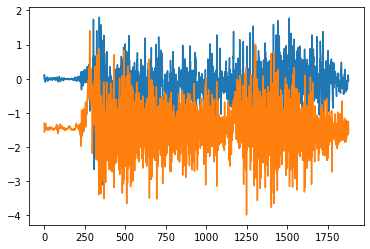

In [8]:
plt.plot(imu_a[:,:-1])

In [9]:
lim_b = 200
imu_a_2d = np.copy(imu_a[:,:-1])
imu_w_2d = np.copy(imu_w[:,-1])
bias_a_2d = np.mean(imu_a_2d[:lim_b], axis=0)
bias_w_2d = np.mean(imu_w[:lim_b])

In [10]:
print(bias_a_2d)
print(bias_w_2d)

[-0.00977362 -1.44911645]
-0.00018316499772481621


## EKF

In [11]:
from lib.ekf_imu_2d import imu_ekf_2d

Please Wait ...
The imu_ekf_2d class is being compiled ...


<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, F))
<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))


The imu_ekf_2d class has been compiled !


In [12]:
yawc_imu = np.pi/2
yawc_compass = np.pi*3/2

imu_t_n = imu_t - imu_t[0]
gnss_t_n = gnss_t - gnss_t[0]

cp_2d = np.zeros_like(imu_a_2d)
cv_2d = np.zeros_like(imu_a_2d)
cyaw = np.zeros(imu_a_2d.shape[0])
cP_2d = np.ones((cv_2d.shape[0], 11, 11)) * 0.1
cba_2d = np.zeros_like(cp_2d)
cbw_2d = np.zeros_like(cyaw)
cbc = np.zeros_like(cyaw)
cbg = np.zeros_like(cp_2d)

cp_2d[0,0] = cs_actual_x[0]
cp_2d[0,1] = cs_actual_y[0]
cyaw[0] = wrap_angle(imu_rpy[0,-1] - yawc_compass)
cba_2d[0] = bias_a_2d
cbw_2d[0] = bias_w_2d
cbc[0] = yawc_compass

var_a = 0.5
var_w = 0.1
var_ba = 0.5
var_bw = 0.001
var_bc =  0.01
var_bg = 0.05#0.05#0.01#0.05

Q = np.zeros((9,9))
Q[:2,:2] = np.eye(2) * var_a
Q[2,2] = var_w
Q[3:5, 3:5] = np.eye(2) * var_ba
Q[5, 5] = var_bw
Q[6, 6] = var_bc
Q[7:,7:] = np.eye(2) * var_bg

J_gnss = np.eye(2) * 4.
J_compass = np.array([[0.075]])

In [13]:
ekf = imu_ekf_2d(cp_2d[0], cv_2d[0], cyaw[0], bias_a_2d, bias_w_2d, cP_2d[0], cbc[0], cbg[0], Q, yawc_imu)

gnss_idx = 1
for k in range(1, imu_a.shape[0]):
    dt = imu_t[k] - imu_t[k - 1]
    
    if (gnss_idx <= gnss_t.shape[0]) and (gnss_t_n[gnss_idx] <= imu_t_n[k-1]):
        ekf.correct_gnss_2d(gnss_p[gnss_idx], J_gnss)
        gnss_idx = gnss_idx + 3
    ekf.predict(dt, imu_a_2d[k-1], imu_w_2d[k-1])
    ekf.correct_compass(imu_rpy[k,-1], J_compass)
    
    cp_2d[k], cv_2d[k], cyaw[k], cba_2d[k], cbw_2d[k], cbc[k], cbg[k] = ekf.get_state()
    cP_2d[k] = ekf.get_cov_sys()

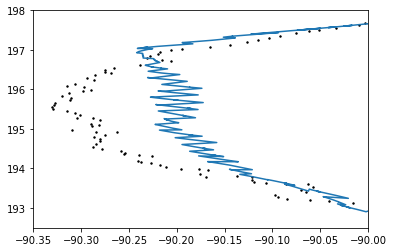

In [14]:
plt.plot(cp_2d[:,0], cp_2d[:,1])
plt.scatter(gnss_p[:,0], gnss_p[:,1],s=2.,color='black')
plt.xlim(-90.35,-90)
plt.ylim(192.5,198)
plt.show()

In [15]:
# plt.plot(cbg)

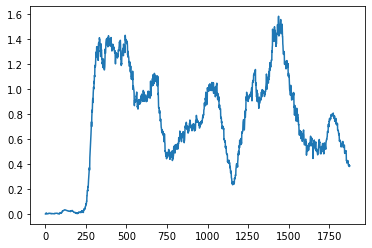

In [16]:
plt.plot(np.linalg.norm(cv_2d,axis=-1))
# plt.plot(cbw_2d)
# plt.plot(cba_2d)

## Yaw Comparison

In [17]:
dgnss = gnss_p[2:] - gnss_p[:-2]
gnss_yaw = np.zeros(gnss_t.shape[0])
gnss_yaw[1:-1] = np.arctan2(dgnss[:,-1], dgnss[:,0])
gnss_yaw[0] = gnss_yaw[1]
gnss_yaw[-1] = gnss_yaw[-2]

In [18]:
gnss_yaw[1:-1].shape

(528,)

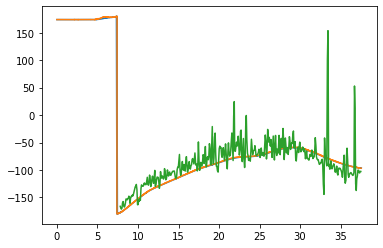

In [19]:
plt.plot(imu_t-imu_t[0], wrap_angle(cyaw)*180/np.pi)
plt.plot(imu_t-imu_t[0], wrap_angle(imu_rpy[:,-1]-np.pi*3/2)*180/np.pi)
lim1 = 110
lim2 = -1
plt.plot(gnss_t[lim1:lim2]-gnss_t[0], (gnss_yaw*180./np.pi)[lim1:lim2])
# plt.xlim(10,15)
# plt.ylim(-160,-70)

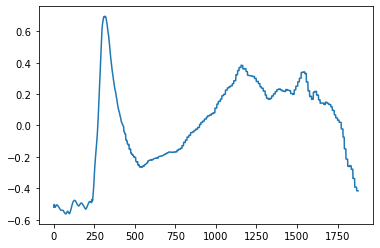

In [20]:
plt.plot((cbc-np.mean(cbc))*180/np.pi)